In [12]:
import numpy as np

import torch
from torch.optim import Adam

from vae import *
from training import *
from utilities import *

import matplotlib.pyplot as plt
import seaborn as sns

### Force covariance matrix to be SDP

## 0. Data simulation

Construction de la matrice de précision

In [2]:
nb_treatments = 2
nb_dim = 1

alpha_y = 1
alpha_a = 1
cond_dependencies_ua =  alpha_a * np.ones(nb_treatments)
cond_dependencies_y =  alpha_y * np.ones(nb_treatments+nb_dim)

L = np.eye(nb_treatments+nb_dim+1)
L[1:1+nb_treatments, 0]  += cond_dependencies_ua
L[-1, :-1]  += cond_dependencies_y

precision = np.matmul(L.T, L)

Simulation des données

In [3]:
nb_obs = 1000

covariance = nearestPD(np.linalg.inv(precision))

data = np.random.multivariate_normal(np.zeros(nb_treatments+nb_dim+1), covariance, nb_obs)

### Preprocessing data

In [4]:
batch_size = 128
train_size = int(nb_obs *.8)

confounders = data[:, 0][None].T
treatments = data[:, 1:nb_treatments+1]
outcomes = data[:, -1][None].T

train = preprocessing(treatments[:train_size, :], outcomes[:train_size, :], confounders[:train_size, :], 
                       batch_size)

valid = preprocessing(treatments[train_size:, :], outcomes[train_size:, :], confounders[train_size:, :], 
                       batch_size)

## 1. VAE


### 1.0 Initialization 

In [5]:
lr = 1e-3
nb_epoch = 1000

vae = VAE(a_dim=nb_treatments, latent_dim=nb_dim)
params = vae.parameters()
optimizer = Adam(params, lr=lr)

### 1.1 Training

In [6]:
model_stack, loss_train_stack, loss_valid_stack = training(train, valid, vae, optimizer, nb_epoch)

### 1.2 Visualization

In [13]:
train = preprocessing(treatments[:train_size, :], outcomes[:train_size, :], confounders[:train_size, :], 
                     batch_size)

treatments_train,  outcomes_train, confounders_train = next(iter(train))


valid = preprocessing(treatments[train_size:, :], outcomes[train_size:, :], confounders[train_size:, :], 
                     batch_size)

treatments_valid,  outcomes_valid, confounders_valid= next(iter(valid))

In [14]:
k= -1

_, _,  _, z_train = model_stack[k](treatments_train)
_, _,  _, z_valid = model_stack[k](treatments_valid)

z_train = z_train.detach().numpy()
z_valid = z_valid.detach().numpy()

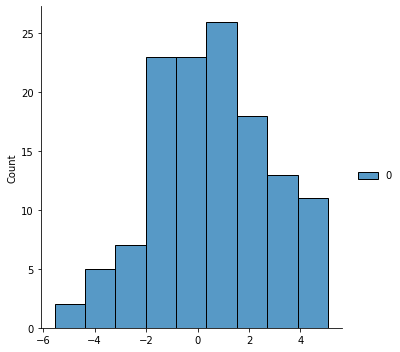

In [15]:
sns.displot(z_train)